# Introduction to Data Science – Homework 5 (February 24, 2023)
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, February 24, 11:59pm.

In this homework you will use linear regression to study house prices in Salt Lake City.

## Your Data
Fill out the following information: 

*First Name:* Melissa   
*Last Name:* Frisby   
*E-mail:* u1175875@utah.edu   
*UID:* u1175875  


## Regression of real estate data
For this problem, you will analyze SLC real estate data. The dataset contains multiple listing service (MLS) real estate transactions for houses sold in 2015-16 in zip code 84103 ([SLC avenues neighborhood](https://www.google.com/maps/place/Salt+Lake+City,+UT+84103/@40.8030372,-111.8957957,12z/data=!3m1!4b1!4m5!3m4!1s0x87525f672006dded:0x311e638d9a1a2de5!8m2!3d40.810506!4d-111.8449346)). We are primarily interested in regressing the `SoldPrice` on the house attributes (`property size`, `house size`, `number of bedrooms`, etc...). 


### Task 1: Import the data 
Use the [`pandas.read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to import the dataset. The data is contained in two files located in the same directory as this notebook: [`train1.csv`](train1.csv) and [`train2.csv`](train2.csv). After you import these files separately, concatenate them into one big dataframe. This pandas dataframe will be used for data exploration and linear regression. 

In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib as mpl

import statsmodels.formula.api as sm

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [2]:
# your code goes here
train1 = pd.read_csv('train1.csv')
train2 = pd.read_csv('train2.csv')
train = pd.concat([train1, train2])

### Task 2: Clean the data 

1. There are 206 different variables associated with each of the 348 houses in this dataset. Skim them and try to get a rough understanding of what information this dataset contains. If you've never seen a real estate listing before, you might take a look at one on [this](http://www.utahrealestate.com/) website to get a better sense of the meanings of the column headers in the dataset.  

+ Only keep houses with List Price between 300,000 and 900,000 dollars both inclusive. This is an arbitrary choice and we realize that some people are high rollers, but for our purposes we'll consider the others as outliers. 

+ Remove columns that you don't think contribute to the value of the house. This is a personal decision – what attributes of a house are important to you? 
You should at least keep the following variables since questions below will use them: `['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude','EWCoord', 'DaysOnMkt', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']` 

+ Check the datatypes and convert any numbers that were read as strings to numerical values. (Hint: You can use [`str.replace()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.replace.html) to work with strings.) If there are any categorical values you're interested in, then you should convert them to numerical values as in Lecture. In particular, convert 'TotSqf' to an integer and add a column titled `Prop_Type_num` that is 
$$
\text{Prop_Type_num}_i = \begin{cases} 
1 & \text{if $i$-th listing is a condo or townhouse} \\
0 & \text{if $i$-th listing is a single family house}
\end{cases}. 
$$
+ Remove the listings with erroneous `Longitude` (one has Longitude = 0) and `Taxes` values (two have unreasonably large values).

In [3]:
# exclude too high or too low prices
price_mask = (train['SoldPrice'] >= 300000) & (train['SoldPrice'] <= 900000)
train = train.loc[price_mask]

# remove columns we will not need
train = train[['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude','EWCoord', 'DaysOnMkt', 
               'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]

# change string values to integers
train['TotSqf'] = train['TotSqf'].str.replace(',', '')
train['TotSqf'] = train['TotSqf'].astype(int)

# create boolean values for property type
train['Prop_Type_num'] = ((train['PropType'] == 'Condo') | (train['PropType'] == 'Townhouse')).astype(int)

# remove high tax values
tax_mask = train['Taxes'] <= 11000
train = train.loc[tax_mask]

# remove bad longitude values
longitude_mask = abs(train['Longitude']) > 0
train = train.loc[longitude_mask]

train

,Acres,Deck,GaragCap,Latitude,Longitude,EWCoord,DaysOnMkt,LstPrice,Patio,PkgSpacs,PropType,SoldPrice,Taxes,TotBed,TotBth,TotSqf,YearBlt,Prop_Type_num
0,0.29,1,3,40.779524,-111.893542,0,7.0,725000,1,0,Single Family,752000,7244,4.0,5.0,5415,1998,0
2,0.11,0,0,40.773972,-111.867470,0,4.0,390000,1,0,Single Family,390000,1816,3.0,1.0,1702,1940,0
3,0.14,0,1,40.783009,-111.872100,579,12.0,445000,1,3,Single Family,443000,3260,3.0,2.0,1756,1940,0
5,0.01,0,2,40.771693,-111.886951,123,12.0,339000,0,2,Condo,334000,2141,3.0,2.0,1368,1976,1
6,0.14,1,2,40.783889,-111.872194,580,NaN,600000,1,2,Single Family,570000,4197,3.0,3.0,2956,1950,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.12,1,1,40.771219,-111.856599,1100,185.0,533800,0,0,Single Family,529000,3928,3.0,3.0,3017,1898,0
142,0.15,1,2,40.779253,-111.893385,0,203.0,549000,0,4,Townhouse,535000,3870,5.0,4.0,3494,1998,1
144,0.01,0,2,40.770904,-111.886201,131,198.0,349999,2,2,Condo,340000,1877,2.0,2.0,1473,1979,1
146,0.07,0,1,40.772835,-111.854867,1157,375.0,330000,0,0,Single Family,310000,2079,5.0,3.0,2094,1886,0


# Task 3: Exploratory data analysis 

1. Explore the dataset. Write a short description of the dataset describing the number of items, the number of variables and check to see if the values are reasonable. 

+ Make a bar chart showing the breakdown of the different types of houses (single family, townhouse, condo). 

+ Compute the correlation matrix and use a heat map to visualize the correlation coefficients. 
    - Use a diverging color scale from -1 to +1 (see `vmin` and `vmax` parameters for [pcolor](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.pcolor.html))
    - Show a legend
    - Make sure the proper labels are visible and readable (see [`xticks`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.xticks.html) and the corresponding [`yticks`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.yticks.html).

+ Make a scatter plot matrix to visualize the correlations. Color-code the dots by property type. For the plot, only use a subset of the columns: `['Acres', 'LstPrice', 'PkgSpacs', 'Patio', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt' ]`. Determine which columns have strong correlations. 

+ Describing your findings. 


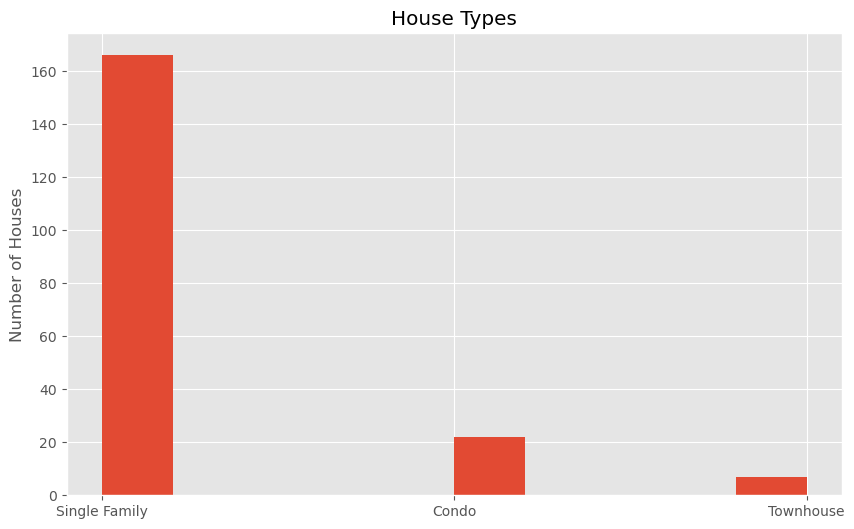

                  Acres      Deck  GaragCap  Latitude  Longitude   EWCoord  \
Acres          1.000000  0.318863  0.396066  0.501626   0.231536  0.245009   
Deck           0.318863  1.000000  0.212336  0.376306   0.038949  0.111616   
GaragCap       0.396066  0.212336  1.000000  0.310459   0.020892  0.069524   
Latitude       0.501626  0.376306  0.310459  1.000000  -0.298723 -0.241166   
Longitude      0.231536  0.038949  0.020892 -0.298723   1.000000  0.910775   
EWCoord        0.245009  0.111616  0.069524 -0.241166   0.910775  1.000000   
DaysOnMkt      0.031771  0.075620  0.168174 -0.060378   0.039503  0.069674   
LstPrice       0.683459  0.411459  0.568874  0.295246   0.337803  0.337618   
Patio          0.153812  0.021695  0.120263  0.111603   0.070929  0.070000   
PkgSpacs       0.130561  0.101846 -0.035109  0.097414   0.019372  0.022483   
SoldPrice      0.672253  0.405385  0.554849  0.299497   0.339189  0.336874   
Taxes          0.646874  0.315717  0.562133  0.316411   0.312616

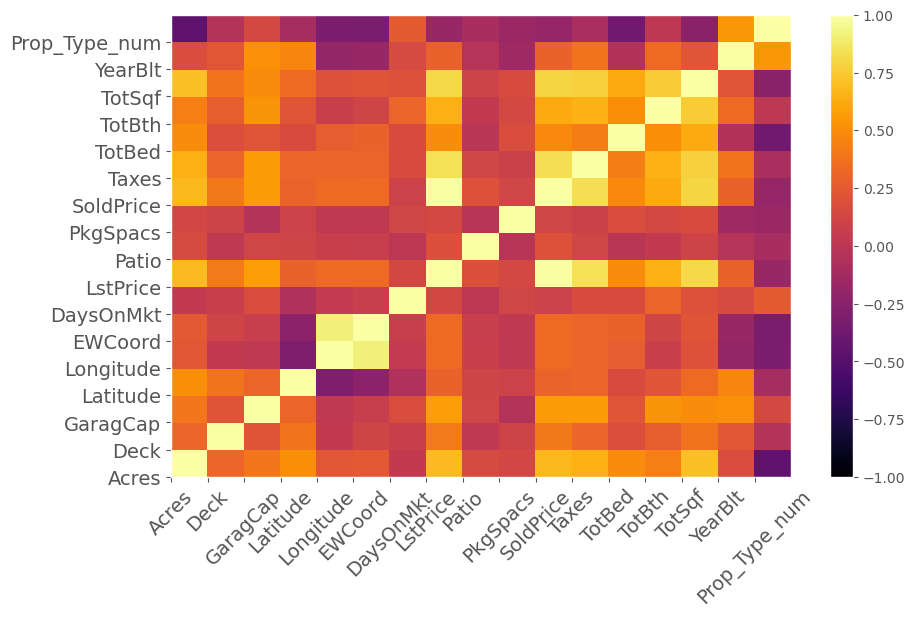

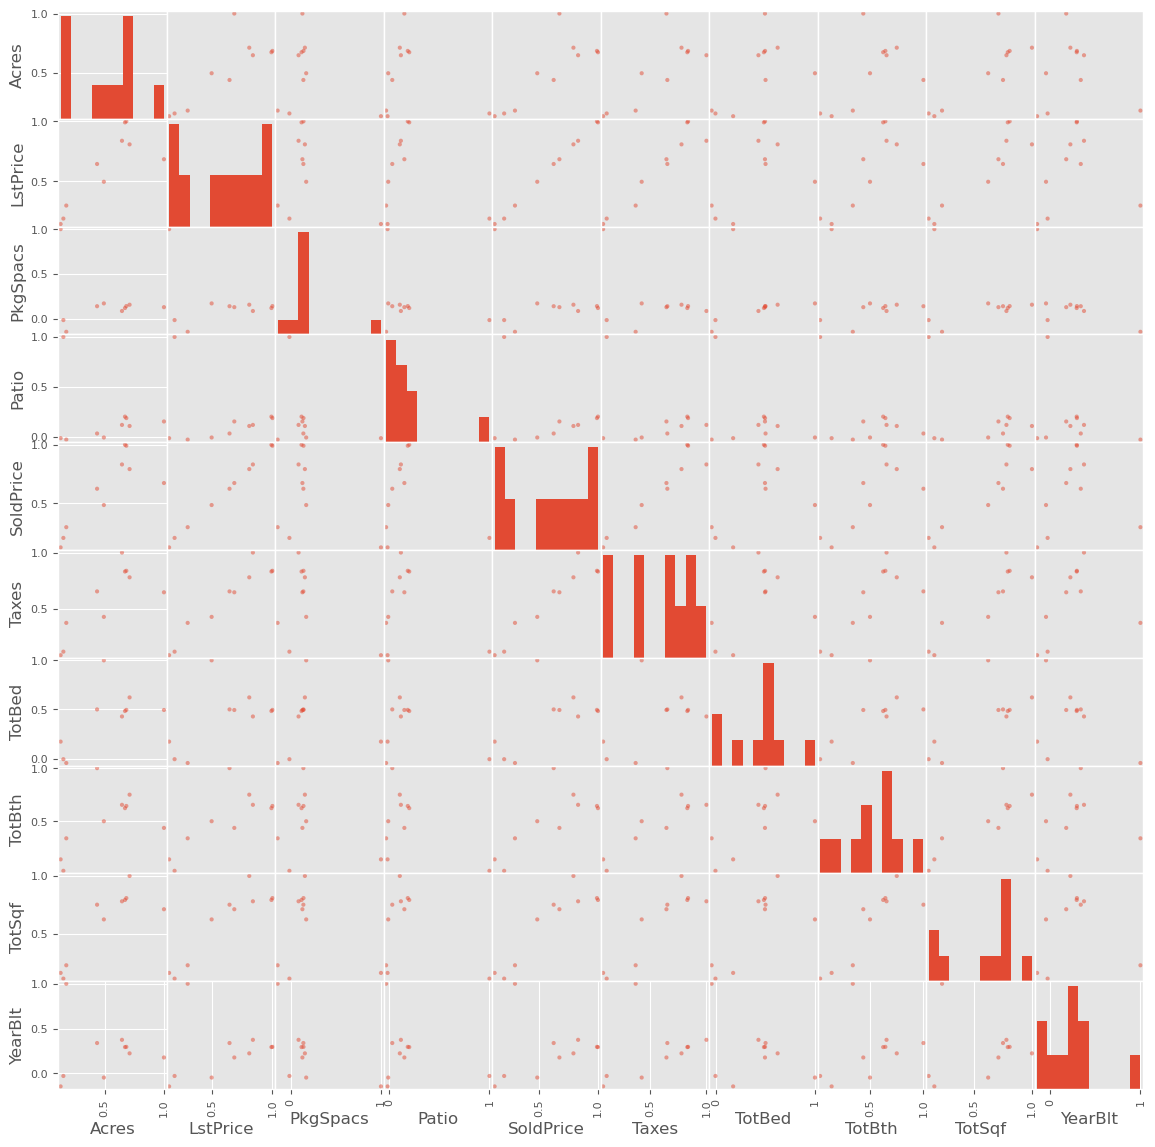

In [4]:
# bar chart of house type
plt.hist(train['PropType'])
plt.title('House Types')
plt.ylabel('Number of Houses')
plt.show()

# list of labels for axes
labels = ['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude','EWCoord', 'DaysOnMkt', 
               'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']

# correlation matrix
print(train.corr())
plt.pcolor(train.corr(), cmap = 'inferno', vmin = -1, vmax = 1);
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1, vmax=1, clip=False), cmap= 'inferno'))
plt.xticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14)
plt.show()

# scatter plot matrix
scatter_mat = train[['Acres', 'LstPrice', 'PkgSpacs', 'Patio', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]
pd.plotting.scatter_matrix(scatter_mat.corr(), figsize = (14, 14,), diagonal = 'hist');

**Your Interpretation:** Most houses being sold in 2016 are single family houses rather than townhouses or condos. The highest correlations are the obvious ones: sold price and list price, square footage vs number of bed/bath, sold price and taxes, acres and total square feet. However, there is a trend between year built and sold price/taxes, with a slight correlation to size while the acres are not correlated at all. This suggests houses are bigger and more expensive despite having the same amount of space as in previous years.

### Task 4: Geospatial plot
Two of the variables are the latitude and longitude of each listing. Salt Lake City is on this nice east-west, north south grid, so even a simple plot of lat and long makes sense. Create a scatterplot of these two variables. Use color to indicate the price of the house. How does the price depend on the house location?

What can you say about the relation between the location and the house price?
 

Text(0, 0.5, 'Longitdue')

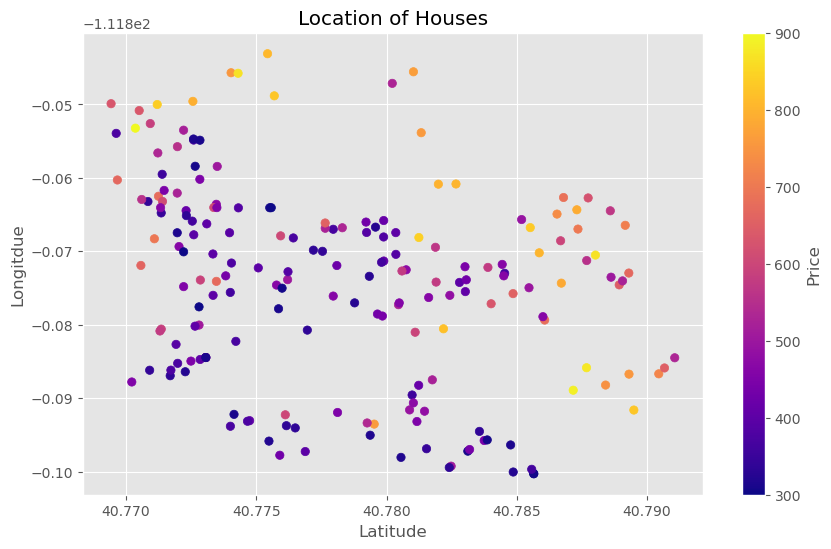

In [5]:
# your code goes here.
plt.scatter(train['Latitude'], train['Longitude'], c = train['SoldPrice'], cmap = 'plasma');
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=300, vmax=900, clip=False), cmap= 'plasma'))
cbar.set_label('Price')
plt.title('Location of Houses')
plt.xlabel('Latitude')
plt.ylabel('Longitdue')

**Your Interpretation:** The houses along the outer rim of SLC have higher selling prices than those closer to the denser area of SLC. They likely have a better view, more land, or a more desirable location than closer to downtown.

### Task 5: Simple  Linear Regression 
Use the `ols` function from the [statsmodels](http://www.statsmodels.org/stable/index.html) package to regress the Sold price on some of the other variables. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x, 
$$
where $x$ is one of the other variables. 

You'll find that the best predictor of sold price is the list price. Report the R-squared value for this model (`SoldPrice ~ LstPrice`) and give an interpretation for its meaning. Also give an interpretation of $\beta_1$ for this model. Make a scatterplot of list price vs. sold price and overlay the prediction coming from your regression model. 

In [6]:
# Your code here
sold_bed = sm.ols(formula = 'SoldPrice ~ TotBed', data = train).fit()
sold_bath = sm.ols(formula = 'SoldPrice ~ TotBth', data = train).fit()
sold_sqf = sm.ols(formula = 'SoldPrice ~ TotSqf', data = train).fit()
sold_list = sm.ols(formula = 'SoldPrice ~ LstPrice', data = train).fit()
sold_acres = sm.ols(formula = 'SoldPrice ~ Acres', data = train).fit()
sold_year = sm.ols(formula = 'SoldPrice ~ YearBlt', data = train).fit()
print(sold_bed.summary())
print(sold_bath.summary())
print(sold_sqf.summary())
print(sold_list.summary())
print(sold_acres.summary())
print(sold_year.summary())

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     58.98
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           7.80e-13
Time:                        10:37:43   Log-Likelihood:                -2584.5
No. Observations:                 195   AIC:                             5173.
Df Residuals:                     193   BIC:                             5180.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.599e+05   3.21e+04      8.102      0.0

**Your Interpretation:** The R-squared value is 0.983, which means there is a positive correlation between list price and sold price. It suggests that the sold price increases with list price, which makes sense when considering housing.

### Task 6: Multilinear Regression 
Develop a multilinear regression model for house prices in this neighborhood. We could use this to come up with a list price for houses coming on the market, so do not include the list price in your model and, for now, ignore the categorical variable Prop_Type. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots +  \beta_n x_n, 
$$
where $x_i$ are predictive variables.


**Question 1**: If we wanted to start a 'house flipping' company, we'd have to be able to do a better job of predicting the sold price than the list price does. How does your model compare? 

Next look at the difference between list price and sold price explicitly. Calculate two new columns for your dataset. `DiffPriceAbsolute` and `DiffPriceRelative`.

* `DiffPriceAbsolute` - This is difference between sold price and list price. If it is positive, that means the house sold for more than it was listed at.
* `DiffPriceRelative` - This is the relative difference between sold price and list price. A value of 1.1 here means that the house sold for 110% of the asking price, and 0.9 means the house sold for 90% of the asking price.

Now, create two new models. One to predict `DiffPriceAbsolute`, and one to predict `DiffPriceRelative`. Use the same predictive variables as i the last model.


**Question 2**: Which of these two new models makes better predictions.

**Question 3**: Based on your answer to question two, why are these models different/the same.

To help justify your answer to question 3, train two models to predict `DiffPriceAbsolute` and `DiffPriceRelative` based on just `SoldPrice`. In addition, for each model make a scatterplots similar to Task 5 for these models.

In [29]:
# your code goes here
# get model of best variables
sold_pr = sm.ols(formula = 'SoldPrice ~ Deck + GaragCap + Longitude + Patio + Taxes + TotSqf', data = train).fit()
print(sold_pr.summary())

# create price difference columns
train['DiffPriceAbsolute'] = train['SoldPrice'] - train['LstPrice']
train['DiffPriceRelative'] = train['SoldPrice']/train['LstPrice']

# new models
diff_abs = sm.ols(formula = 'DiffPriceRelative ~ Deck + GaragCap + Longitude + Patio + Taxes + TotSqf', data = train).fit()
diff_rel = sm.ols(formula = 'DiffPriceAbsolute ~ Deck + GaragCap + Longitude + Patio + Taxes + TotSqf', data = train).fit()

print(diff_abs.summary())
print(diff_rel.summary())

# sold price as only a function of diff
diff_abs = sm.ols(formula = 'DiffPriceRelative ~ SoldPrice', data = train).fit()
diff_rel = sm.ols(formula = 'DiffPriceAbsolute ~ SoldPrice', data = train).fit()

print(diff_abs.summary())
print(diff_rel.summary())

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     113.5
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           9.20e-60
Time:                        11:15:31   Log-Likelihood:                -2461.2
No. Observations:                 195   AIC:                             4936.
Df Residuals:                     188   BIC:                             4959.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.692e+08   4.79e+07      3.531      0.0

**Your Interpretation:** Question 1: Without using the list price, we can predict the sold price with an R-squared of 0.784. However, the R-squared is going to be higher if list price is considered.
Questiong 2: Of the two new models, the relative difference makes better predictions based on the R-squared values, and the variables have more significance than in the absolute model. 
Question 3: The relative difference has a better R-squared and the sold price is more significant to the model.

### Task 7: Incorporating a categorical variable

Above, we considered houses, townhouses, and condos together, but here we'll distinguish between them. Consider the two regression models: 
$$
\text{SoldPrice} = \beta_0 + \beta_1 \text{Prop_Type_num}
$$
and 
$$
\text{SoldPrice} = \beta_0  + \beta_1 \text{Prop_Type_num} + \beta_2 \text{TotSqf}
$$
From the first model, it would appear that Property type is significant in predicting the sold price. On the other hand, the second model indicates that when you take into account total square footage, property type is no longer predictive. Explain this. (Hint: there is a confounder lurking here.) Make a scatterplot of TotSqf vs. SoldPrice where the house types are colored differently to illustrate your explanation. 

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     7.146
Date:                Tue, 21 Feb 2023   Prob (F-statistic):            0.00816
Time:                        12:23:06   Log-Likelihood:                -2606.9
No. Observations:                 195   AIC:                             5218.
Df Residuals:                     193   BIC:                             5224.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.066e+05   1.21e+04     41.942

Text(0.5, 1.0, 'Sold Price vs Square Feet with House Type')

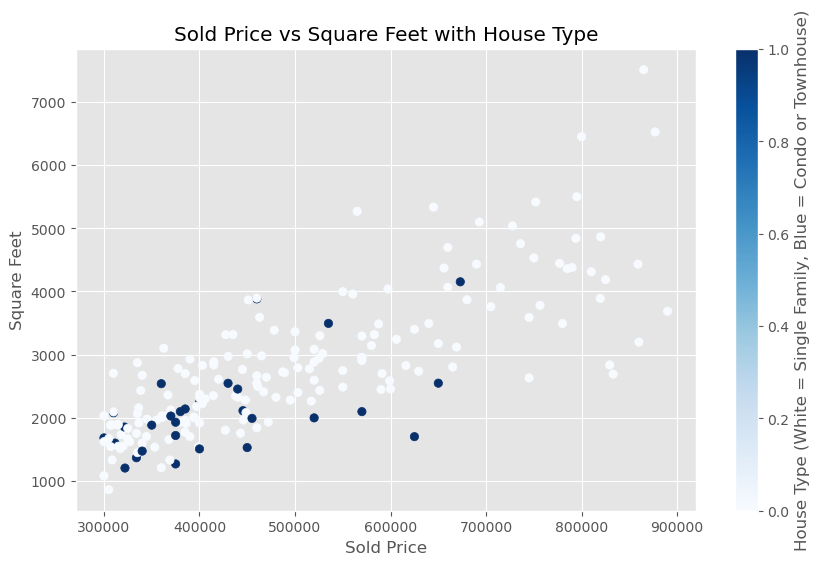

In [40]:
# Your code goes here
prop = sm.ols(formula = 'SoldPrice ~ Prop_Type_num', data = train). fit()
sqf = sm.ols(formula = 'SoldPrice ~ Prop_Type_num + TotSqf', data = train).fit()

print(prop.summary())
print(sqf.summary())

# plot totsqf vs soldprice
plt.scatter(train['SoldPrice'], train['TotSqf'], c = train['Prop_Type_num'], cmap = 'Blues');
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1, clip=False), cmap= 'Blues'))
cbar.set_label('House Type (White = Single Family, Blue = Condo or Townhouse)')
plt.xlabel('Sold Price')
plt.ylabel('Square Feet')
plt.title('Sold Price vs Square Feet with House Type')

**Your Interpretation:** Property type becomes insignificant because the square feet of the house becomes more important. A condo or townhouse will have lower square footage than a single family house, so the property type does not matter as much.